In [334]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.signal import find_peaks as fp
from sklearn import preprocessing

In [335]:
path = 'example.txt'
df_raw = pd.read_csv(path, sep='\t', names=['shift','intensity'], index_col = 'shift')

In [336]:
'''
NOISE CLEARING.
To perform proper analysis on the RAMAN spectrum, it is necessary to perform noise cleaning on the raw data.
This cleaning includes silicon spectrum subtraction, analysis range limits, normalization and signal smoothing.
'''
# Spectral Substraction of Silicon
reference_path = 'reference.txt'
df_reference =  pd.read_csv(reference_path, sep='\t', names=['shift','intensity'], index_col = 'shift')
df = df_raw - df_reference

# Shift Range Reduction
upper_bound = 3000
lower_bound = 1000
df = df.loc[lower_bound:upper_bound]

# Normalization
df = abs(df)/df.max()

# Save Clean Data


In [353]:
df.to_csv('example_noiseless.txt',sep='\t', index=True, header = False)

In [337]:
'''
PEAK FINDING.

'''
height = 0.05
prominence = 0.02
distance = None 
p, _ = fp(x=df.intensity,height = height, prominence = prominence, distance = distance)
peaks = df.iloc[p]

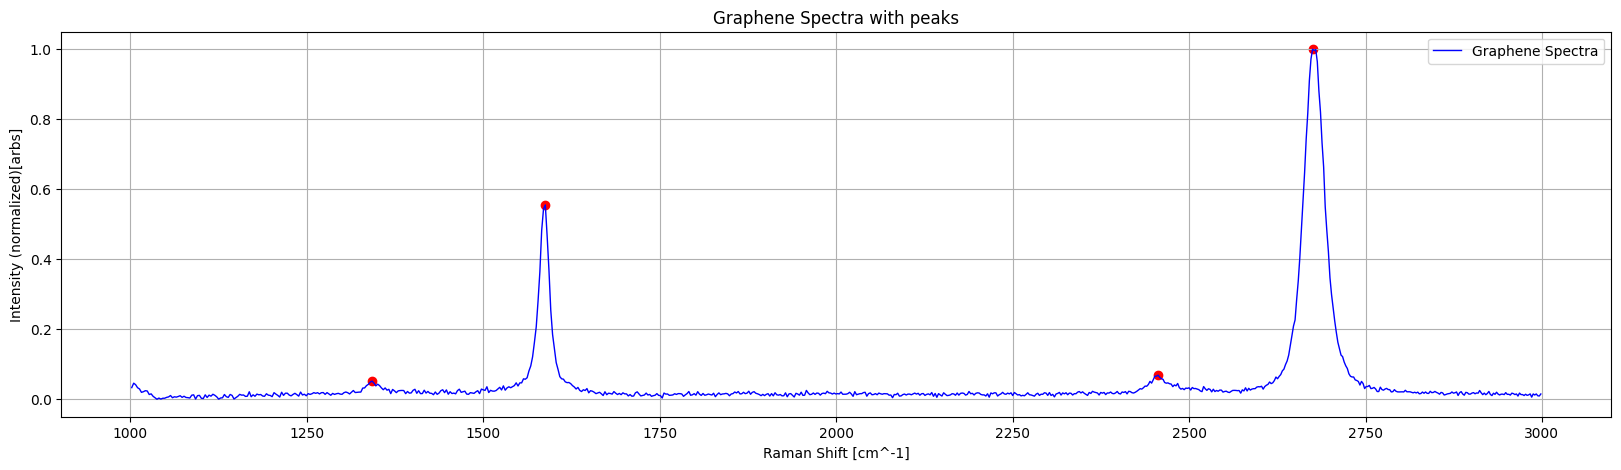

In [338]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra',color='b')
ax.scatter(peaks.index.values,peaks, color='r')
ax.grid()
ax.set_ylabel('Intensity (normalized)[arbs]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title('Graphene Spectra with peaks')
ax.legend()
plt.show()

In [355]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = np.loadtxt('example_noiseless.txt', unpack=True )
yData = yData / max(yData)

generalWidth = 1

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmin( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - max( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ),maxfev = 5000)
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print(popt)
testData = [ multi_lorentz(x, popt ) for x in xData ]

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xData, yData )
ax.plot( xData, testData )
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_15944\4011537960.py:31: RuntimeWarning: Number of calls to function has reached maxfev = 5000.
  popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ),maxfev = 5000)


KeyboardInterrupt: 

In [378]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def pato(array_x0):
    a= []
    for i in array_x0:
        a.append(i)
        return a

In [379]:
pato(peaks.index.values)

[1342.33175257789]

In [367]:
peaks.index.values

array([1342.33175258, 1587.81652583, 2456.17053177, 2674.96881779])

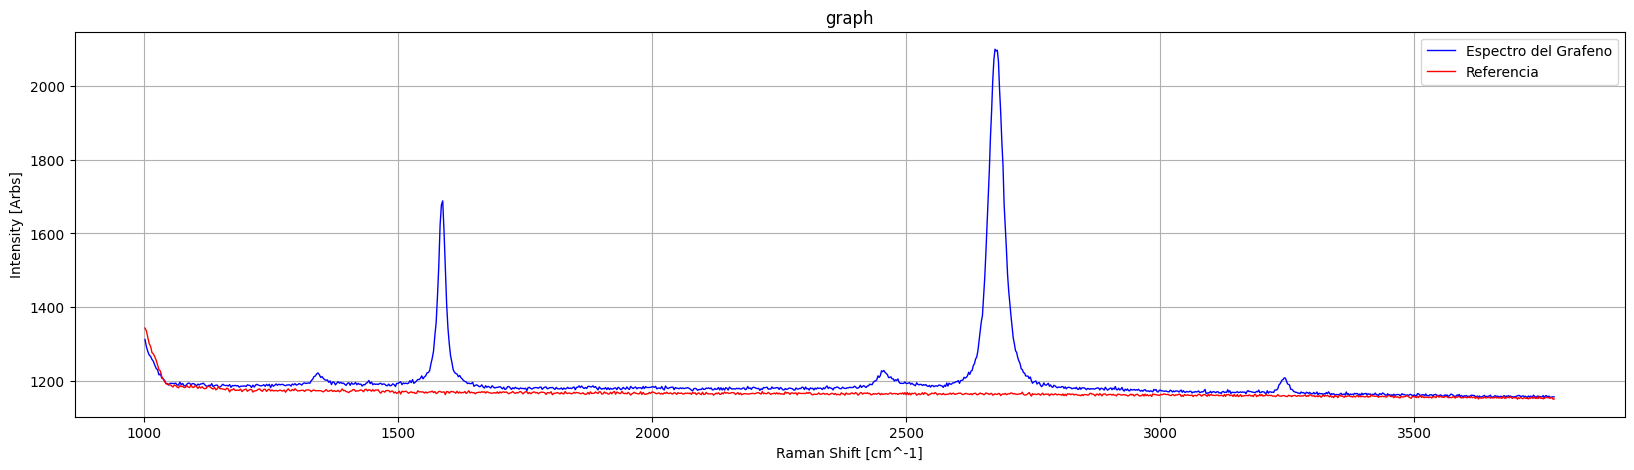

In [310]:
'''subir a la parte de limpieza de ruido'''
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
raman_shift = raman_df['shift'][raman_df['shift']>1000]
arb_intensity= raman_df['intensity'][raman_df['shift']>1000]
silicon_shift = reference_df['shift'][raman_df['shift']>1000]
silicon_intensity= reference_df['intensity'][raman_df['shift']>1000]
ax.plot(raman_shift,arb_intensity,linewidth=1,label='Espectro del Grafeno',color="b")
ax.plot(silicon_shift,silicon_intensity,linewidth=1,label='Referencia',color="r")
ax.grid()
ax.set_ylabel('Intensity [Arbs]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title('graph')
ax.legend()
plt.show()

In [351]:
df.values


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
La idea sería que conocemos las x_0 para todos los máximos
Además conocemos la longitud total de la multilorenziana